In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *

%load_ext autoreload
%autoreload 2

# 2c2 Snekhorn
> Better kernels, better curvature

What we discovered in 2C1 is that kernel parameters not only have a large effect on the reported curvature, but that none of the kernels we have with any parameterization seems accurate in capturing high-dimensional curvature. Indeed, even with small kernel bandwidths, for example using k=5 with a kNN kernel, the bandwidth in dimension 4 is sufficiently large that extrinsic effects dominate the curvature. With our entropic measure, this results in a *reversed* curvature measurement. With the wasserstein measurement, it becomes a measure of *any* curvature - and reports higher values for both saddles and spheres than planes.

We hypothesize that this effect reveals the inadequacy of a traditional k-nearest neighbor's terminal. Even when the bandits are computed adaptively, they only depend on the distance of the k-neighbor, not the distances of all of the others, with the result that the distribution of distances is ignored. In low dimensions, this isn't so bad; we can find a value of k that works. In high dimensions the effects rae much worse.

In this notebook, we investigate using a new kernel construction published in NeurIPS 2023: SNEkhorn.

In [ ]:
import asyncio

import logging
logging.getLogger().setLevel(logging.ERROR)


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

# SNEKhorn Prelims

In [ ]:
from snekhorn.affinities import SymmetricEntropicAffinity, EntropicAffinity, BistochasticAffinity
perp = 15
SEA = SymmetricEntropicAffinity(perp=perp, lr=1e-1, max_iter=1000, square_parametrization=True)
bisto_a = BistochasticAffinity(eps=2)
EA = EntropicAffinity(perp=perp, normalize_as_sne=True)

In [ ]:
from diffusion_curvature.datasets import *
import torch

In [ ]:
X, ks_torus = torus(2000, use_guide_points=True)
X = torch.tensor(X)

In [ ]:
#%%
Pds = bisto_a.compute_affinity(X)
Psne = EA.compute_affinity(X)

f mean :  8.773e-09, f std :  1.273e-07, begin mean


How long does a computation of the Symmetric Entropic Affinity matrix take? How many iterations are needed?

In [ ]:
%%time
Pse = SEA.compute_affinity(X)

---------- Computing the symmetric entropic affinity matrix ----------


perps mean :  1.500e+01, perps std :  9.834e-03, ma

---------- Warning: max iter attained, algorithm stops but may not have converged ----------
CPU times: user 6min 16s, sys: 12.4 s, total: 6min 29s
Wall time: 24.4 s


Let's visualize each of these.

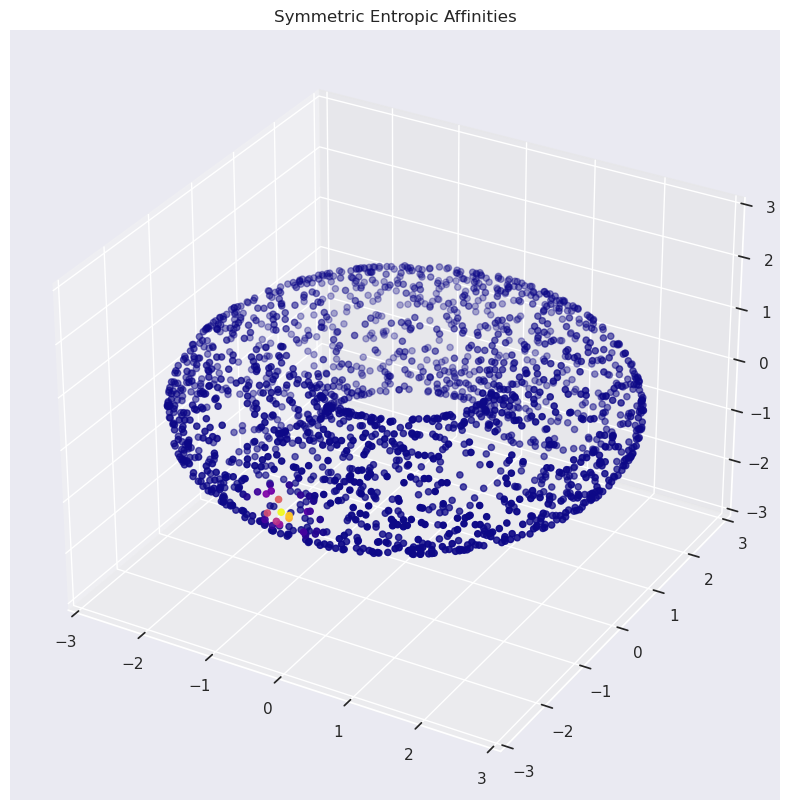

In [ ]:
plot_3d(X, Pse[0],"Symmetric Entropic Affinities")

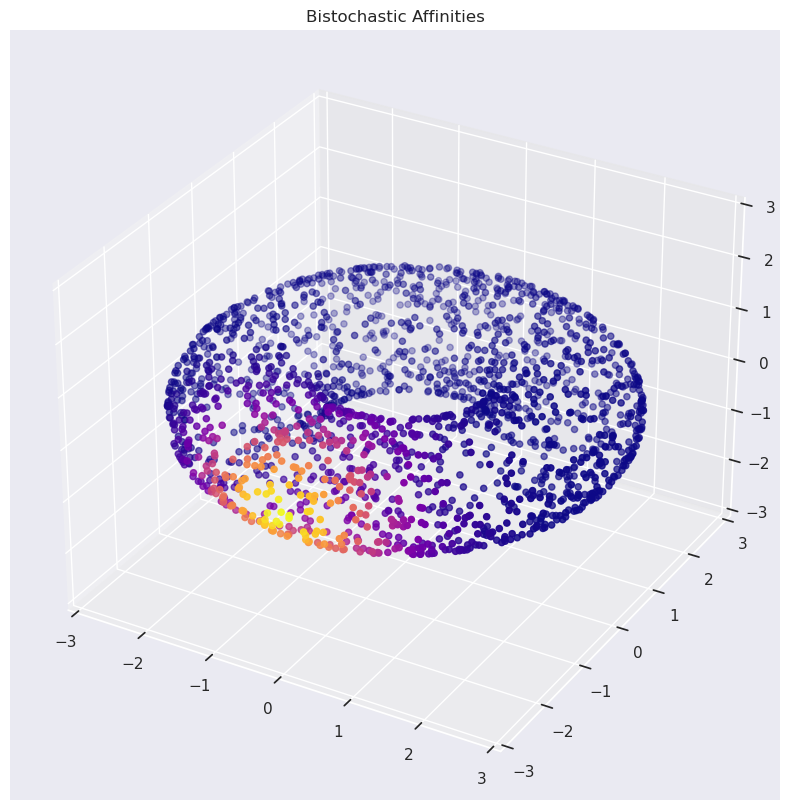

In [ ]:
plot_3d(X, Pds[0],"Bistochastic Affinities")

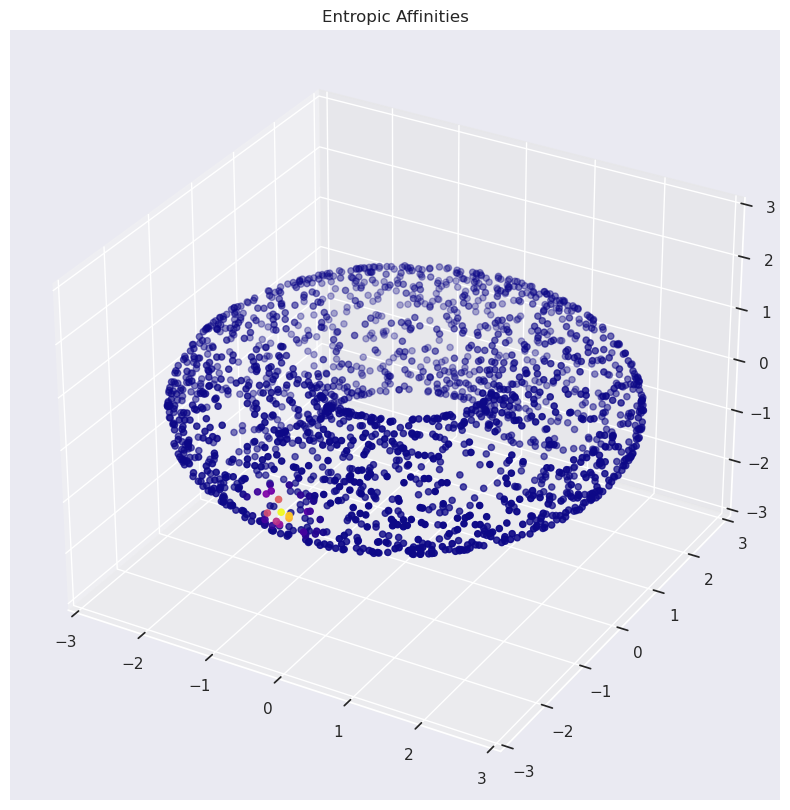

In [ ]:
plot_3d(X, Pse[0],"Entropic Affinities")

Both of the entropic affinity variants are extremely small. One suspects possibly too small. Nonetheless, let's see how the graphs perform.

In [ ]:
from snekhorn.affinities import SymmetricEntropicAffinity, EntropicAffinity, BistochasticAffinity
import torch
from diffusion_curvature.core import SimpleGraph
def SEA_graphformer(X, perplexity=5):
    if type(X) != np.ndarray:
        X = np.asarray(X)
    X = torch.from_numpy(X)
    SEA = SymmetricEntropicAffinity(perp=perplexity, lr=1e-1, max_iter=1000, square_parametrization=True, verbose=False)
    W = SEA.compute_affinity(X)
    G = SimpleGraph(W)
    return G

def EA_graphformer(X, perplexity=5):
    if type(X) != np.ndarray:
        X = np.asarray(X)
    X = torch.from_numpy(X)
    EA = EntropicAffinity(perp=perplexity, normalize_as_sne=True, verbose=False)    
    W = EA.compute_affinity(X)
    G = SimpleGraph(W)
    return G

def BS_graphformer(X, epsilon=2):
    if type(X) != np.ndarray:
        X = X.numpy()
    X = torch.tensor(X)
    bisto_a = BistochasticAffinity(eps=epsilon, verbose=False)
    W = bisto_a.compute_affinity(X)
    G = SimpleGraph(W)
    return G

In [ ]:
G_torus = SEA_graphformer(X)

100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]


In [ ]:
G_torus = EA_graphformer(X)

# Entropic Affinities - Dimension 2

In [ ]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 26, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, perplexity, t):
    global SS
    graph_former = partial(EA_graphformer, perplexity=perplexity)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=t)
    SS.update(ks[0], method_name=f"DC with {perplexity=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for perplexity in [15,20,25,30]:
        for t in [25,30,35,40,50,80,120]:
            tasks.append(asyncio.create_task(process_alpha_k(X, perplexity, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|       | 0/24 [00:00<?, ?it/s]
Processing X's:   4%| | 1/24 [00:45<17:30, 45.67s/i
Processing X's:   8%| | 2/24 [01:24<15:18, 41.74s/i
Processing X's:  12%|▏| 3/24 [02:02<13:57, 39.88s/i
Processing X's:  17%|▏| 4/24 [02:40<13:00, 39.02s/i
Processing X's:  21%|▏| 5/24 [03:15<11:58, 37.81s/i
Processing X's:  25%|▎| 6/24 [03:52<11:14, 37.48s/i
Processing X's:  29%|▎| 7/24 [04:29<10:34, 37.33s/i
Processing X's:  33%|▎| 8/24 [05:05<09:51, 36.94s/i
Processing X's:  38%|▍| 9/24 [05:43<09:18, 37.24s/i
Processing X's:  42%|▍| 10/24 [06:21<08:45, 37.50s/
Processing X's:  46%|▍| 11/24 [06:58<08:06, 37.40s/
Processing X's:  50%|▌| 12/24 [07:36<07:31, 37.60s/
Processing X's:  54%|▌| 13/24 [08:14<06:54, 37.65s/
Processing X's:  58%|▌| 14/24 [08:51<06:13, 37.37s/
Processing X's:  62%|▋| 15/24 [09:28<05:36, 37.37s/
Processing X's:  67%|▋| 16/24 [10:05<04:58, 37.33s/
Processing X's:  71%|▋| 17/24 [10:41<04:18, 36.91s/
Processing X's:  75%|▊| 18/24 [11:19<03:41, 36.99s/
Processing 

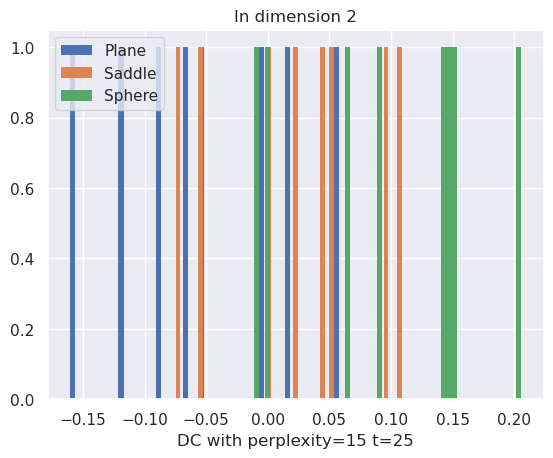

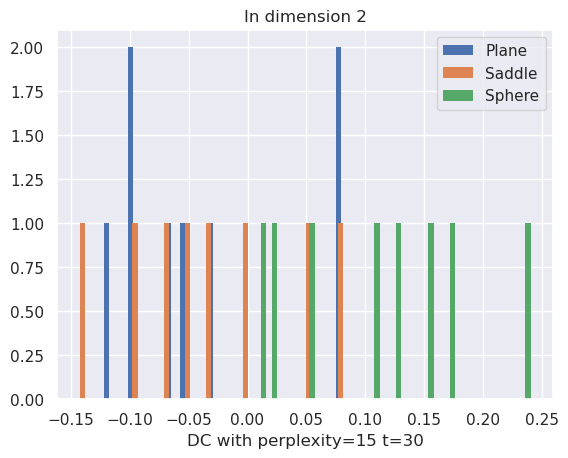

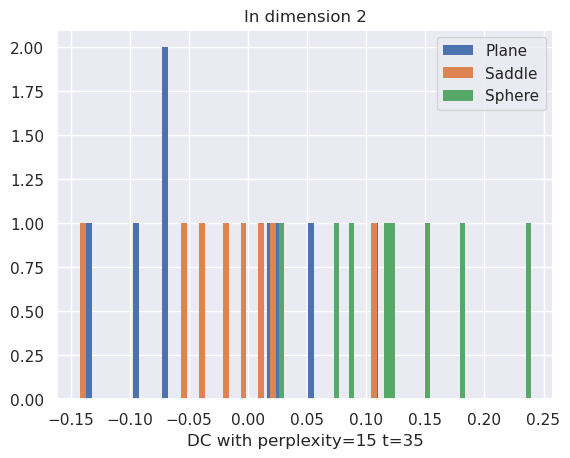

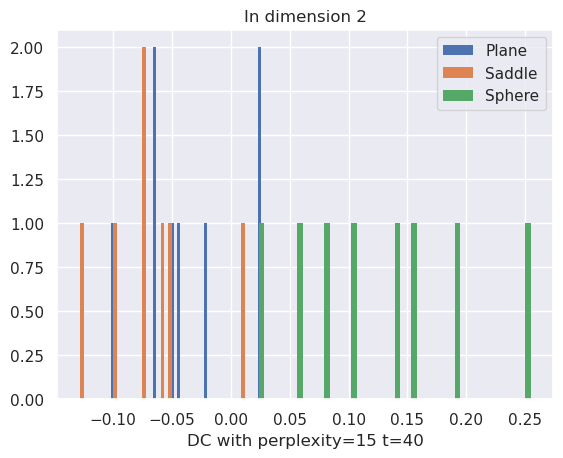

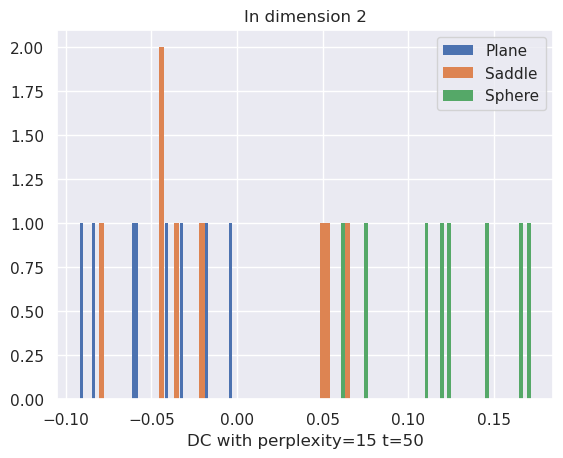

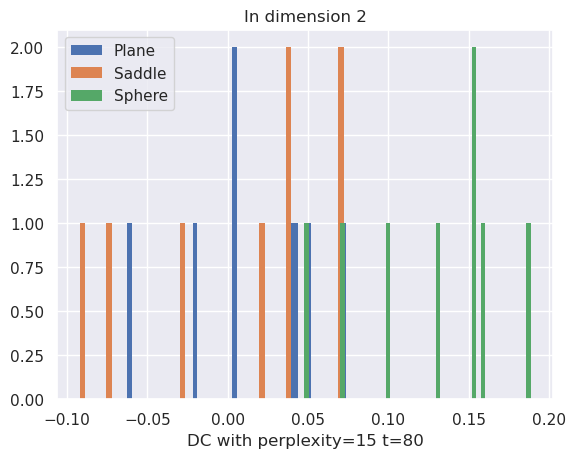

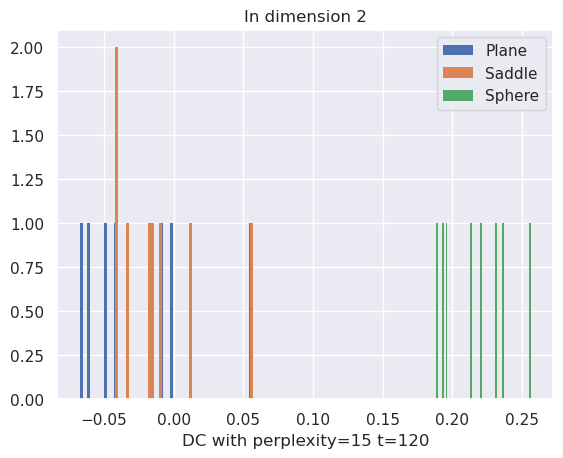

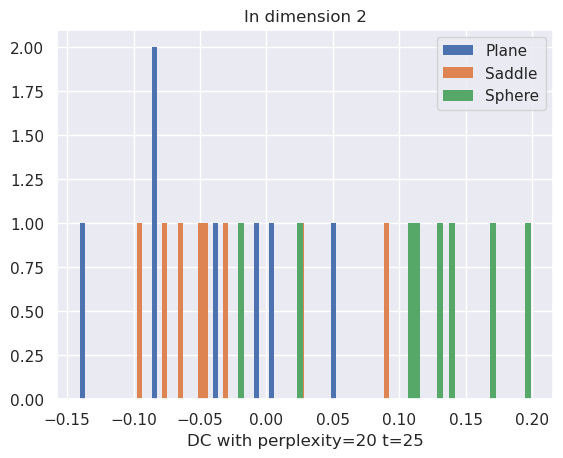

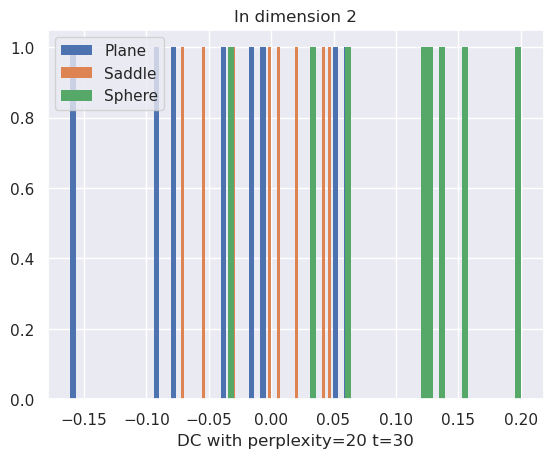

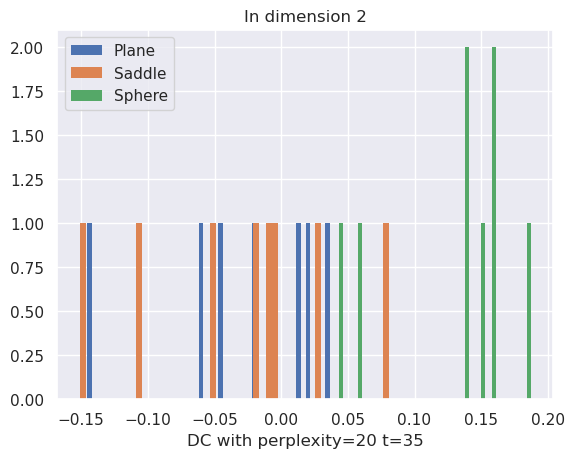

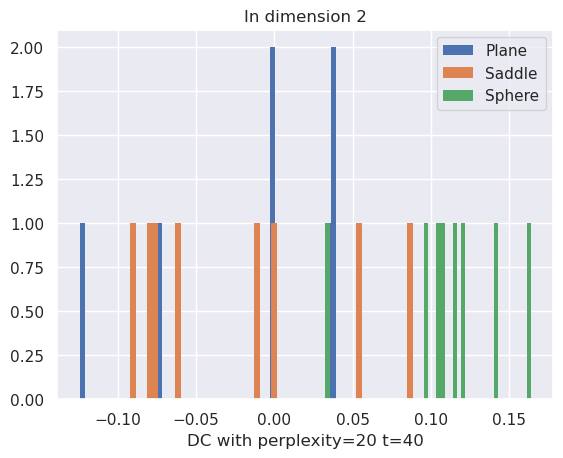

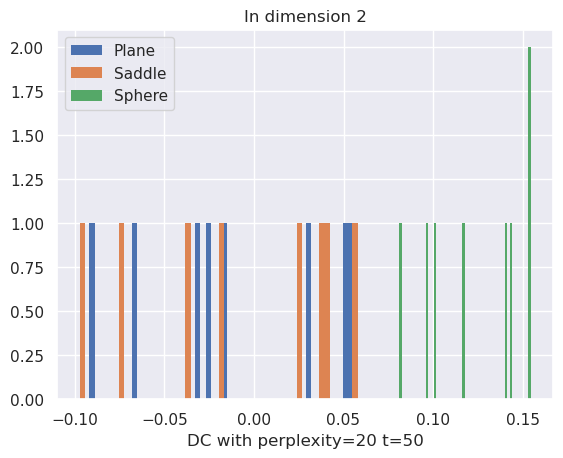

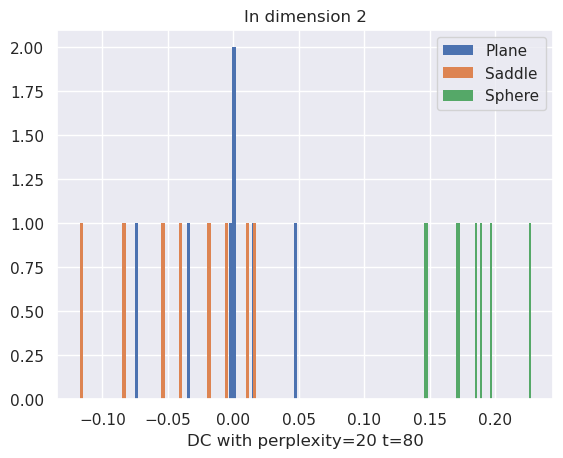

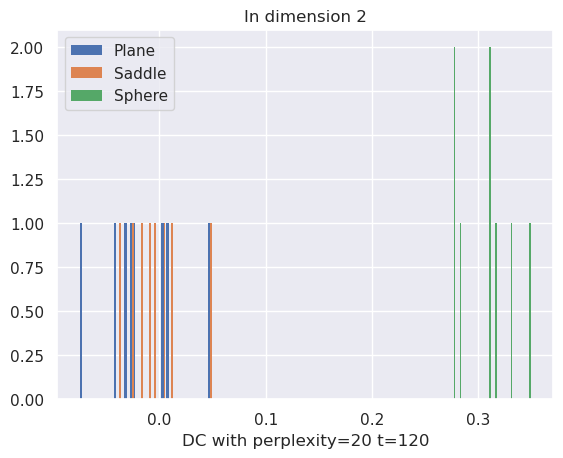

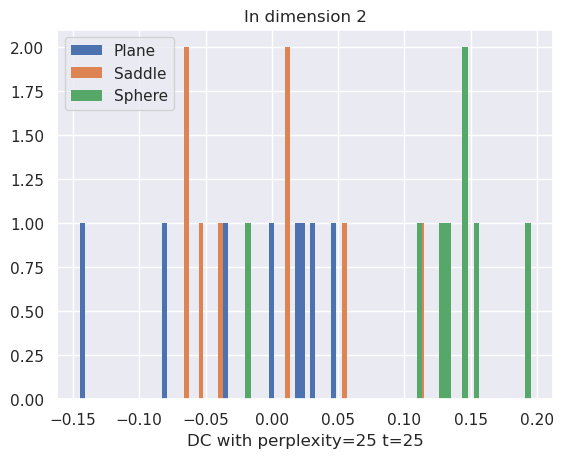

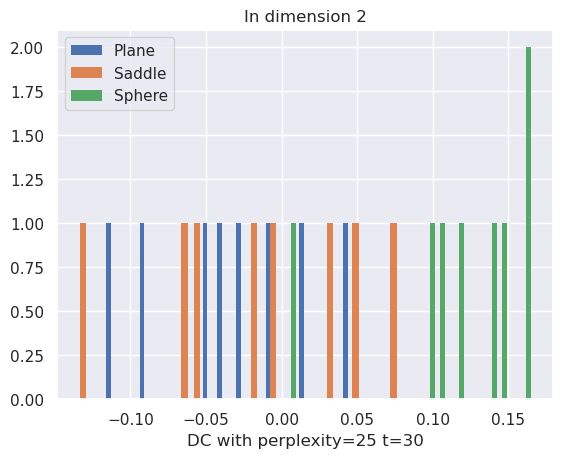

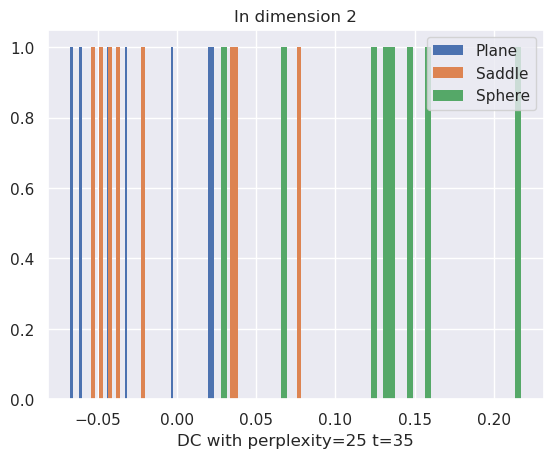

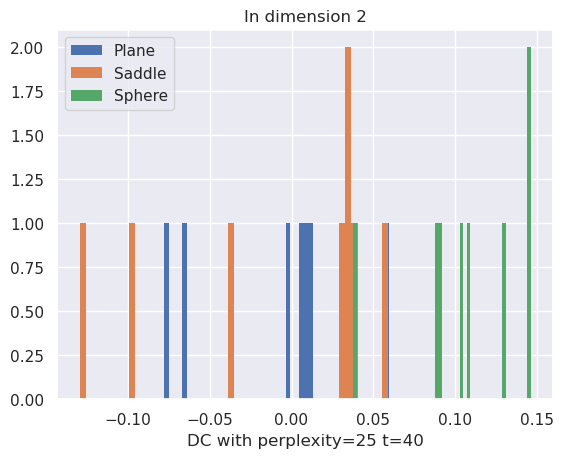

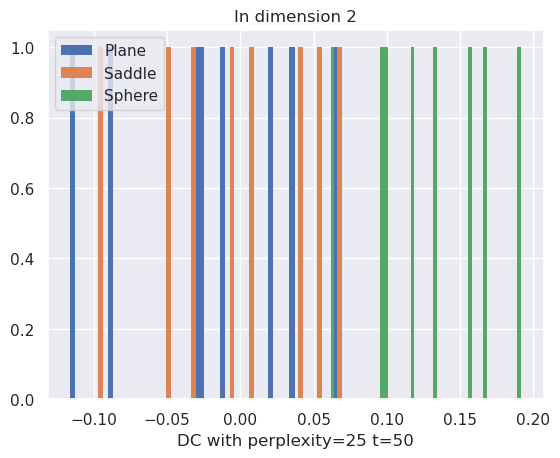

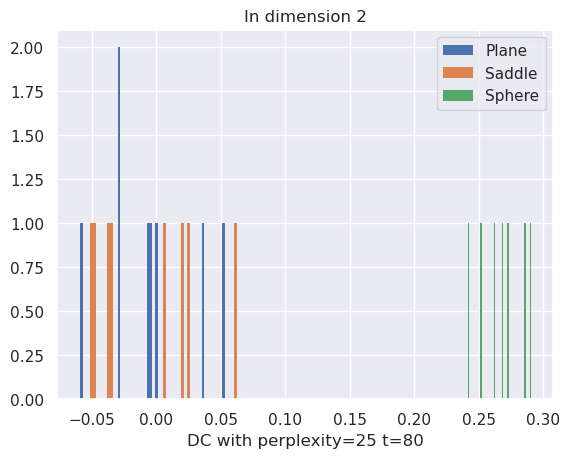

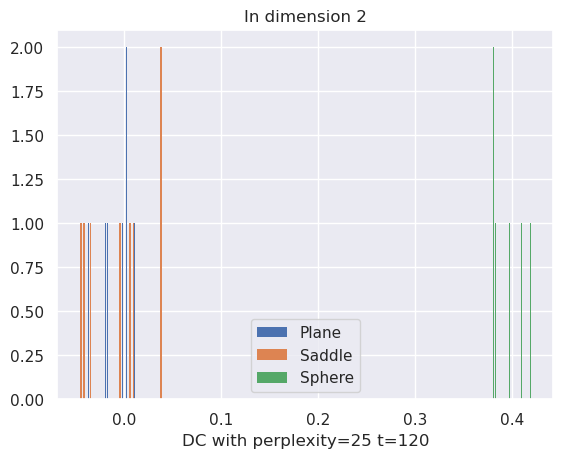

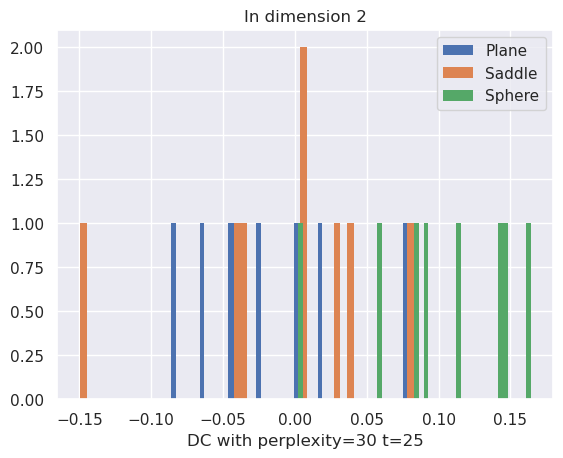

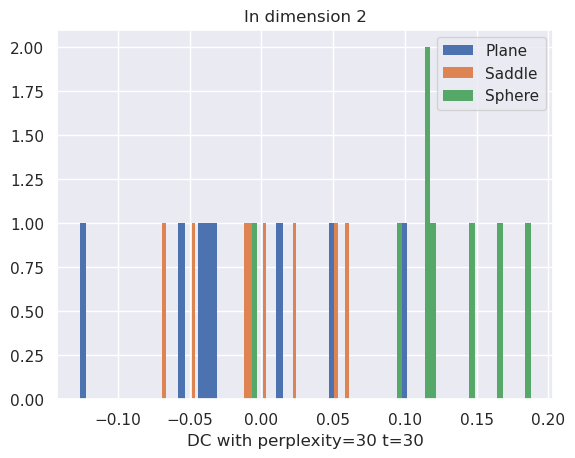

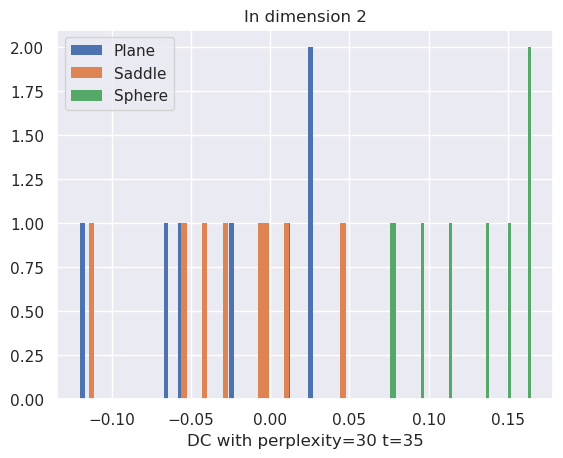

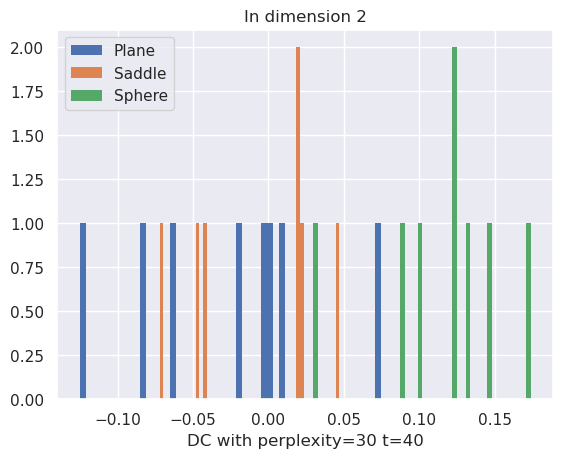

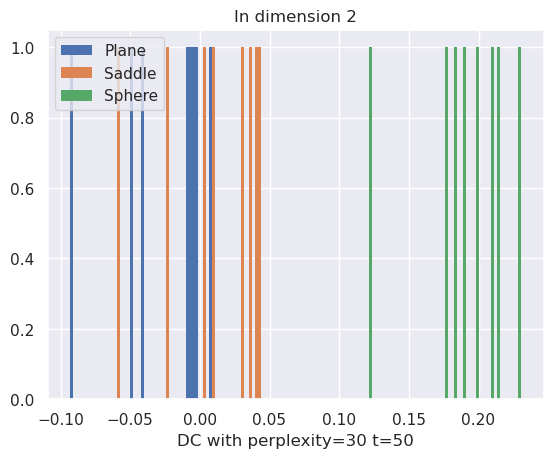

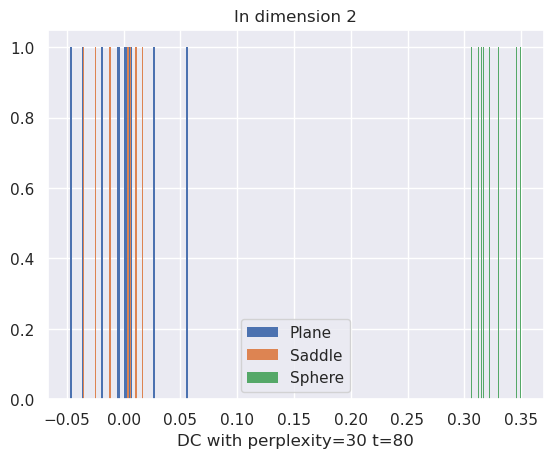

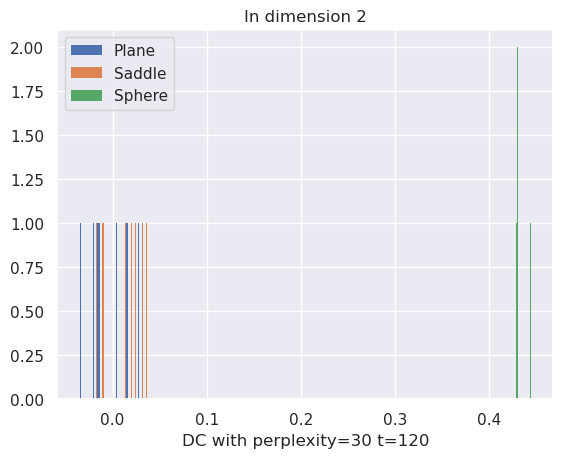

pearson_r  \
ks                                              (0.9999999999999999, 0.0)   
DC with perplexity=15 t=25      (0.12469638953418288, 0.5615455993356602)   
DC with perplexity=15 t=30       (0.434932345441424, 0.03366914510705234)   
DC with perplexity=15 t=35    (0.43241410762847554, 0.034829247490072796)   
DC with perplexity=15 t=40     (0.5991255182301674, 0.001977005192205306)   
DC with perplexity=15 t=50     (0.40014575713940176, 0.05268561885389522)   
DC with perplexity=15 t=80       (0.530200031404118, 0.00769759149353654)   
DC with perplexity=15 t=120    (0.5961082093100389, 0.002111593679048737)   
DC with perplexity=20 t=25    (0.43251513712452355, 0.034782102606204374)   
DC with perplexity=20 t=30      (0.3325327765644699, 0.11236087468361294)   
DC with perplexity=20 t=35      (0.5256987730166167, 0.00833231951590127)   
DC with perplexity=20 t=40     (0.5306001152845291, 0.007643178896315783)   
DC with perplexity=20 t=50      (0.5161522226540618, 0.00982316450221159)   
DC with perplexity=20 t=80   (0.6810836665901451, 0.00024861656521263777)   
DC with perplexity=20 t=120   (0.6135074733065226, 0.0014313248910916235)   
DC with perplexity=25 t=25      (0.4273654252081927, 0.03725052624371407)   
DC with perplexity=25 t=30     (0.4404598667021953, 0.031230352370298954)   
DC with perplexity=25 t=35      (0.476020927837419, 0.018706569874383776)   
DC with perplexity=25 t=40     (0.4996779000773318, 0.012912680487687348)   
DC with perplexity=25 t=50     (0.45364778102292164, 0.02597811441509238)   
DC with perplexity=25 t=80    (0.6421778332391653, 0.0007163757401024515)   
DC with perplexity=25 t=120   (0.6439885606366927, 0.0006841383294103813)   
DC with perplexity=30 t=25     (0.40946794971058276, 0.04692357634447006)   
DC with perplexity=30 t=30      (0.41886286502994724, 0.0416273303769965)   
DC with perplexity=30 t=35    (0.5446768569100623, 0.0059224353868163665)   
DC with perplexity=30 t=40     (0.41928984356179405, 0.04139831092202655)   
DC with perplexity=30 t=50     (0.5041907382471601, 0.011996263450759204)   
DC with perplexity=30 t=80    (0.6498198462552235, 0.0005886733654538673)   
DC with perplexity=30 t=120   (0.6258369250255094, 0.0010716371051261893)   

                             sign_score  
ks                             1.098612  
DC with perplexity=15 t=25     0.161083  
DC with perplexity=15 t=30     0.318257  
DC with perplexity=15 t=35     0.209993  
DC with perplexity=15 t=40     0.318257  
DC with perplexity=15 t=50     0.469150  
DC with perplexity=15 t=80     0.103774  
DC with perplexity=15 t=120    0.376636  
DC with perplexity=20 t=25     0.189191  
DC with perplexity=20 t=30     0.145587  
DC with perplexity=20 t=35     0.281705  
DC with perplexity=20 t=40     0.238151  
DC with perplexity=20 t=50     0.209993  
DC with perplexity=20 t=80     0.281705  
DC with perplexity=20 t=120    0.238151  
DC with perplexity=25 t=25     0.059354  
DC with perplexity=25 t=30     0.281705  
DC with perplexity=25 t=35     0.281705  
DC with perplexity=25 t=40     0.121293  
DC with perplexity=25 t=50     0.209993  
DC with perplexity=25 t=80     0.209993  
DC with perplexity=25 t=120    0.209993  
DC with perplexity=30 t=25     0.195472  
DC with perplexity=30 t=30     0.102033  
DC with perplexity=30 t=35     0.281705  
DC with perplexity=30 t=40     0.195472  
DC with perplexity=30 t=50     0.348528  
DC with perplexity=30 t=80     0.152067  
DC with perplexity=30 t=120    0.195472

In [ ]:
SS.plot()
SS.table()

# Entropic Affinities - Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 26, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, perplexity, t):
    global SS
    graph_former = partial(EA_graphformer, perplexity=perplexity)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=t)
    SS.update(ks[0], method_name=f"DC with {perplexity=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for perplexity in [15,20,25,30]:
        for t in [25,30,35,40,50,80,120]:
            tasks.append(asyncio.create_task(process_alpha_k(X, perplexity, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())


Processing X's:   0%|       | 0/24 [00:00<?, ?it/s]
Processing X's:   4%| | 1/24 [00:38<14:44, 38.48s/i
Processing X's:   8%| | 2/24 [01:16<13:58, 38.10s/i
Processing X's:  12%|▏| 3/24 [01:52<12:59, 37.12s/i
Processing X's:  17%|▏| 4/24 [02:27<12:08, 36.41s/i
Processing X's:  21%|▏| 5/24 [03:03<11:27, 36.19s/i
Processing X's:  25%|▎| 6/24 [03:39<10:50, 36.12s/i
Processing X's:  29%|▎| 7/24 [04:14<10:10, 35.92s/i
Processing X's:  33%|▎| 8/24 [04:52<09:42, 36.42s/i
Processing X's:  38%|▍| 9/24 [05:30<09:15, 37.00s/i
Processing X's:  42%|▍| 10/24 [06:07<08:39, 37.08s/
Processing X's:  46%|▍| 11/24 [06:45<08:02, 37.11s/
Processing X's:  50%|▌| 12/24 [07:20<07:20, 36.68s/
Processing X's:  54%|▌| 13/24 [07:55<06:37, 36.09s/
Processing X's:  58%|▌| 14/24 [08:30<05:57, 35.72s/
Processing X's:  62%|▋| 15/24 [09:05<05:19, 35.48s/
Processing X's:  67%|▋| 16/24 [09:40<04:43, 35.50s/
Processing X's:  71%|▋| 17/24 [10:17<04:10, 35.72s/
Processing X's:  75%|▊| 18/24 [10:52<03:34, 35.72s/
Processing 

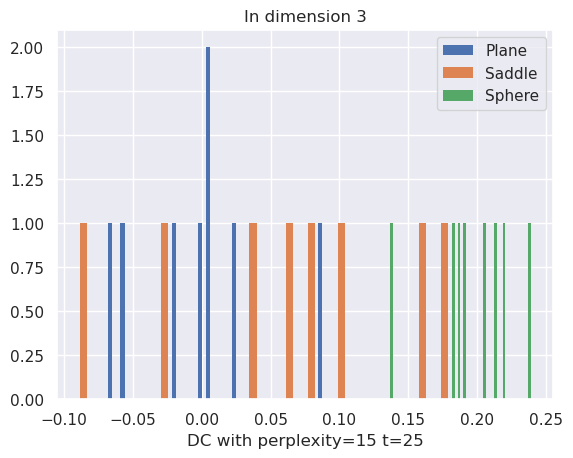

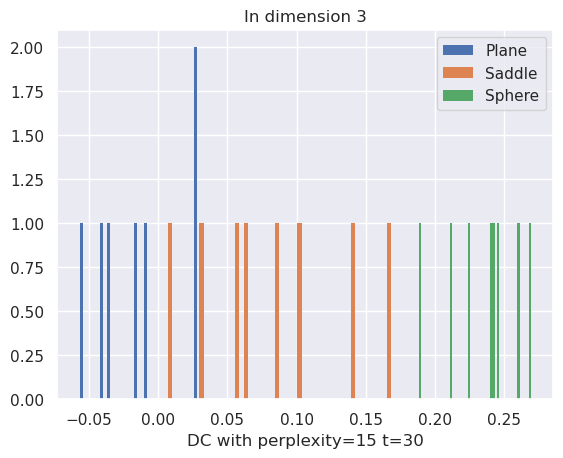

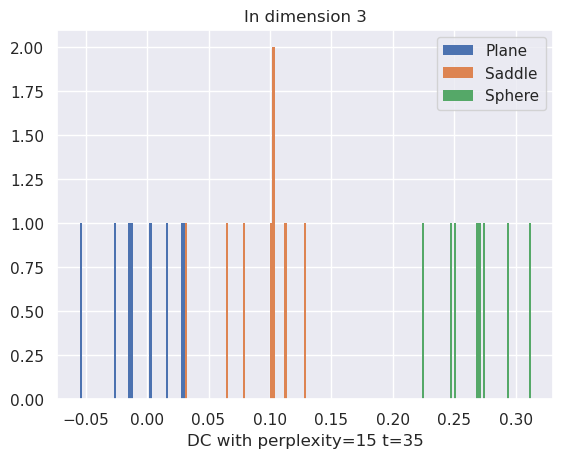

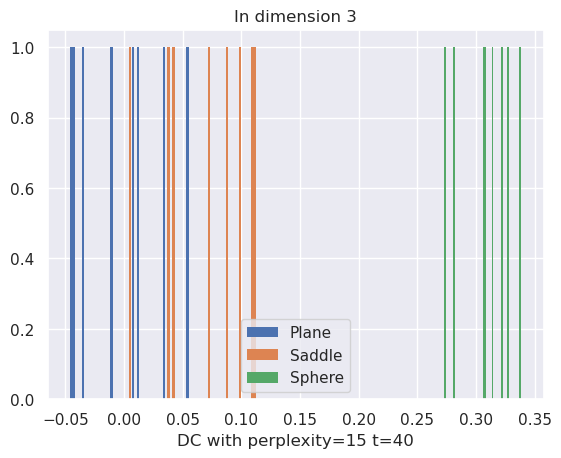

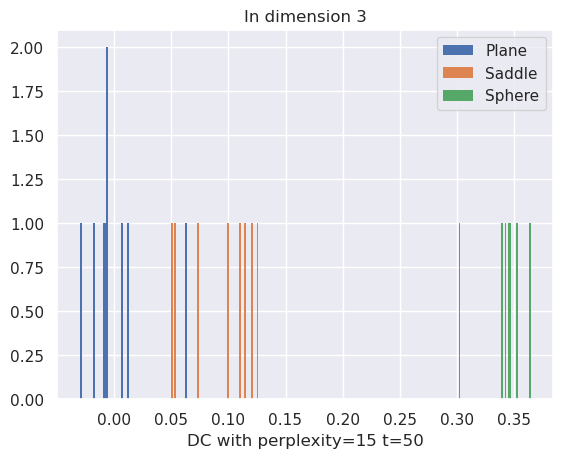

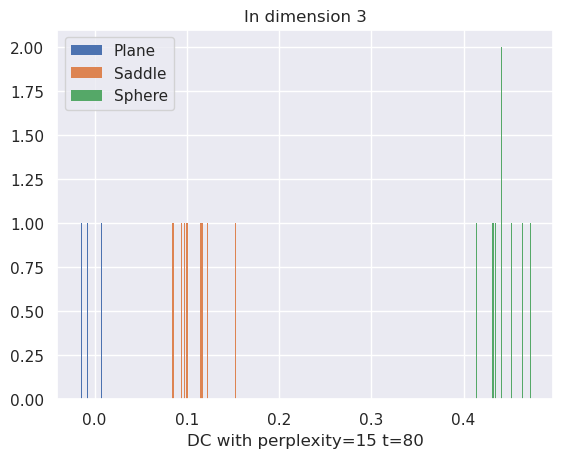

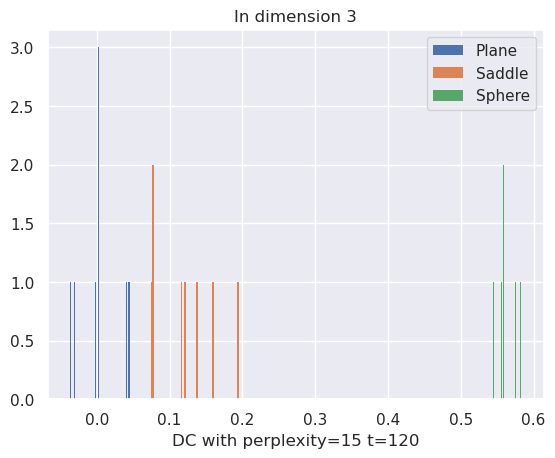

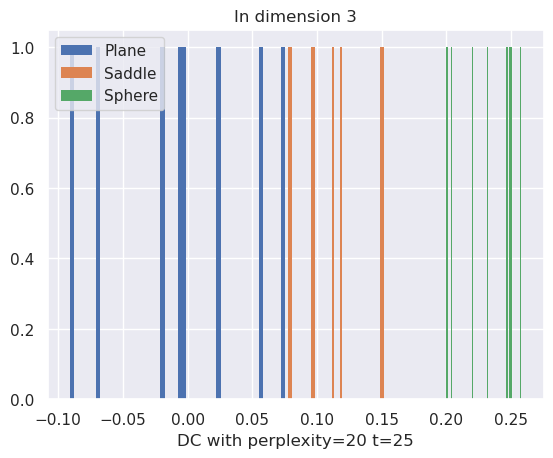

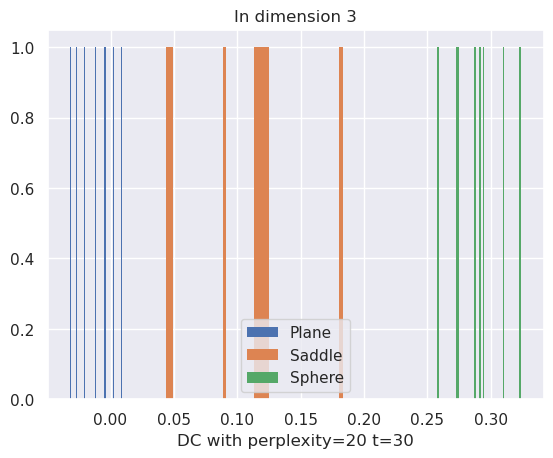

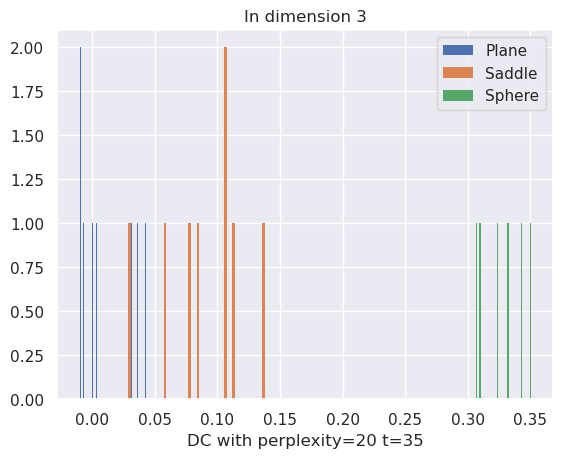

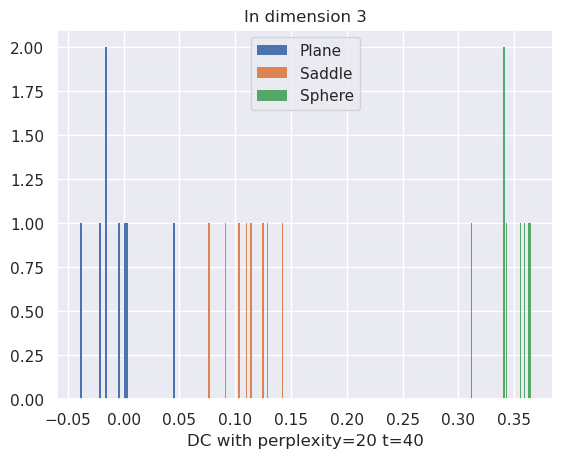

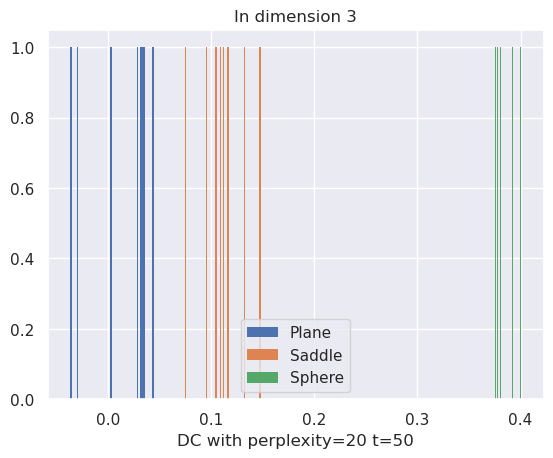

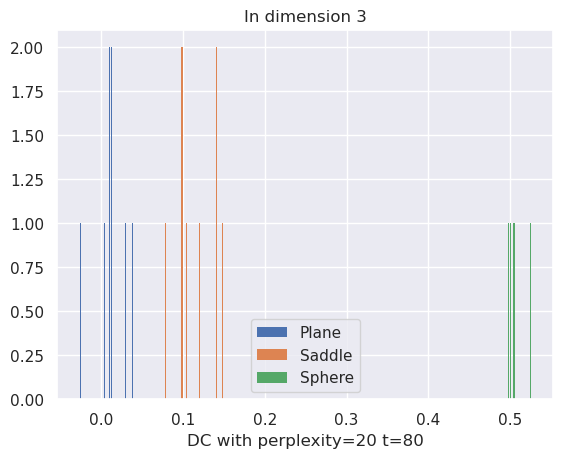

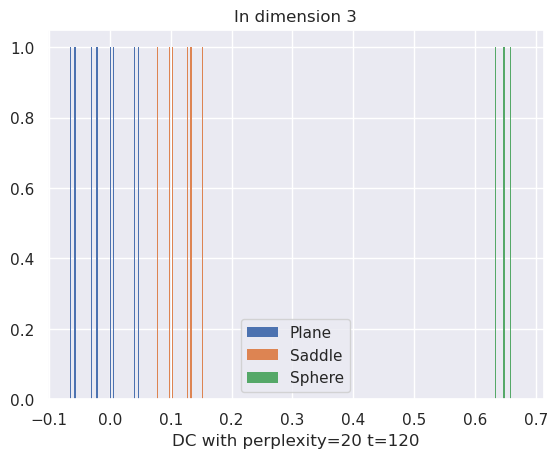

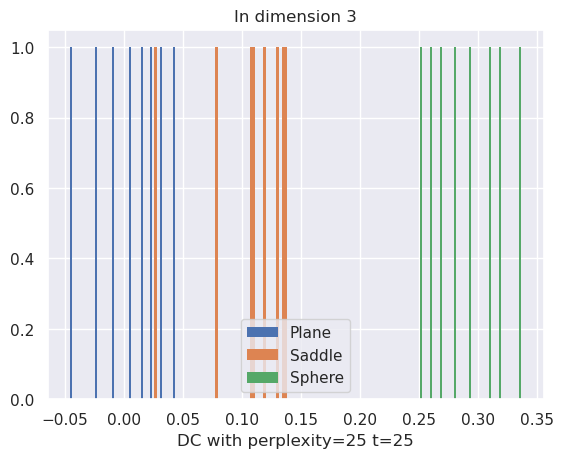

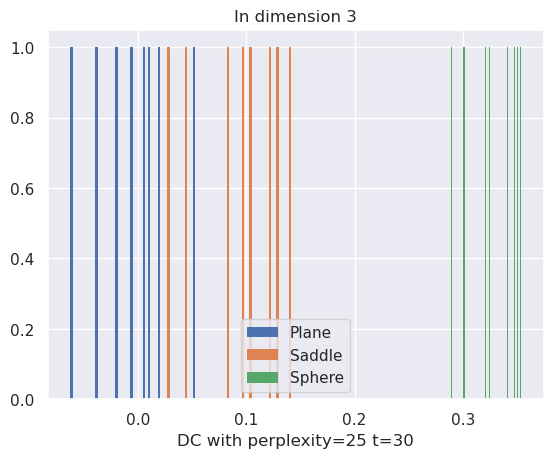

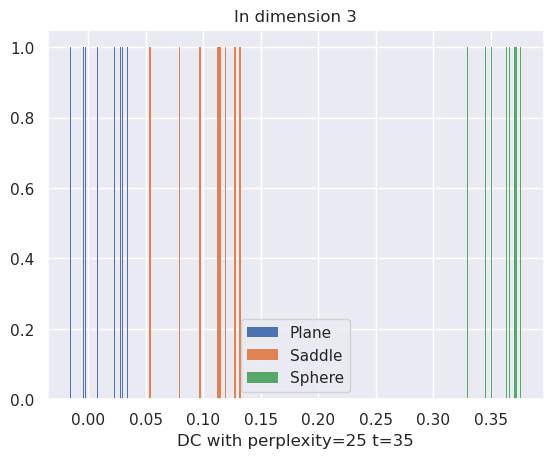

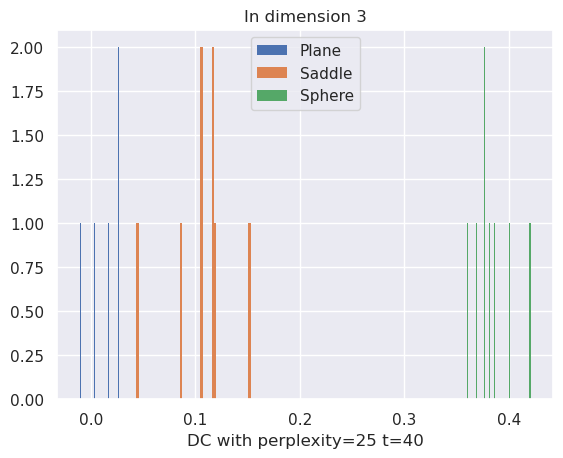

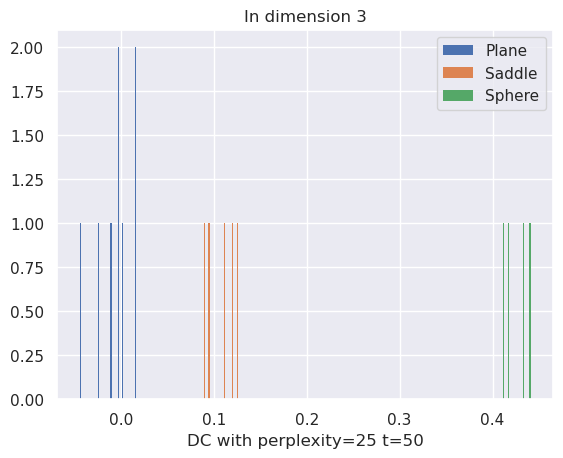

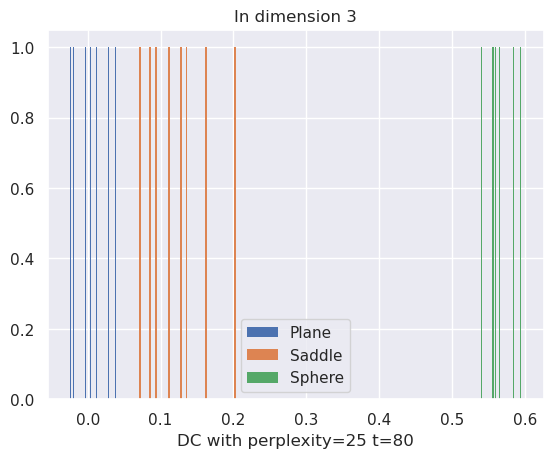

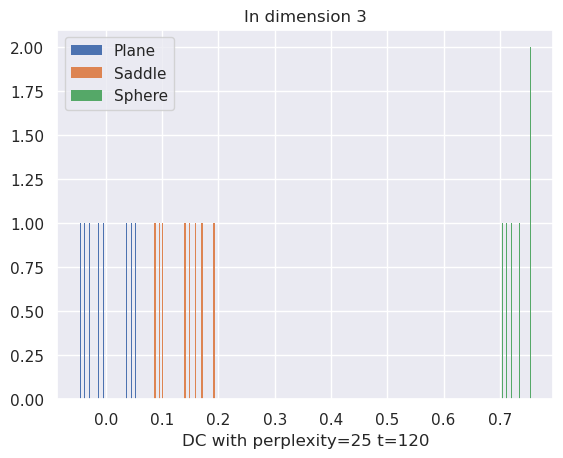

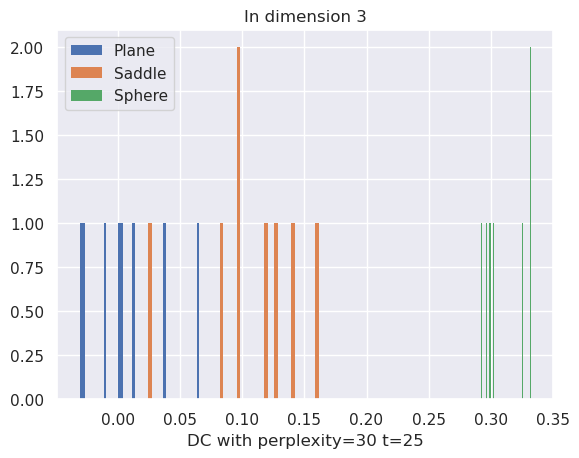

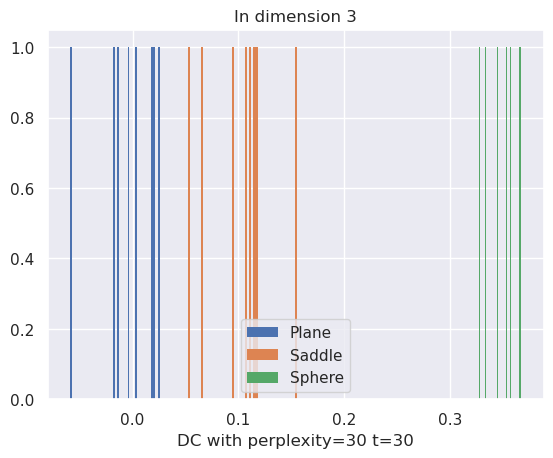

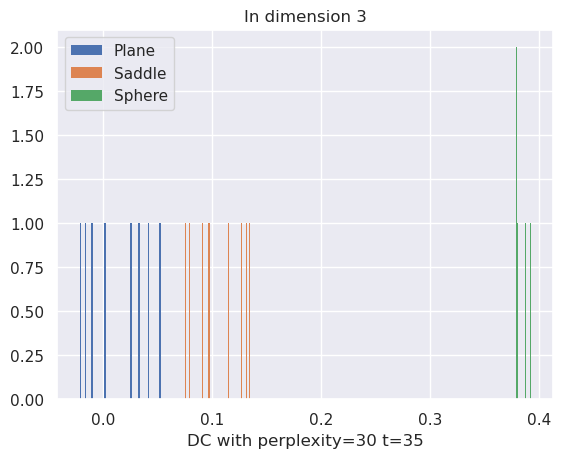

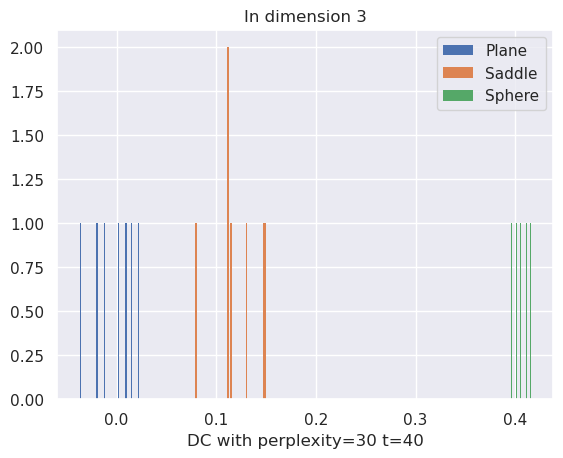

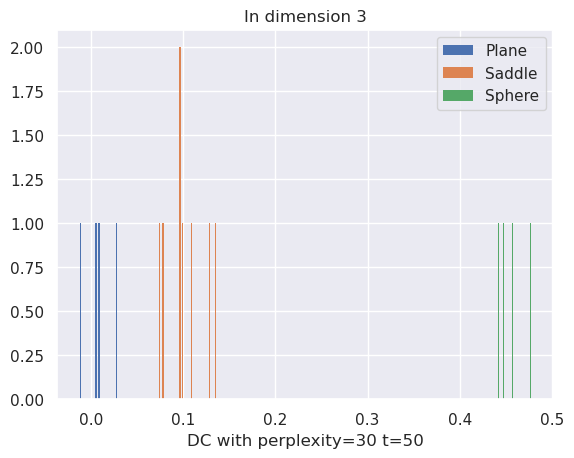

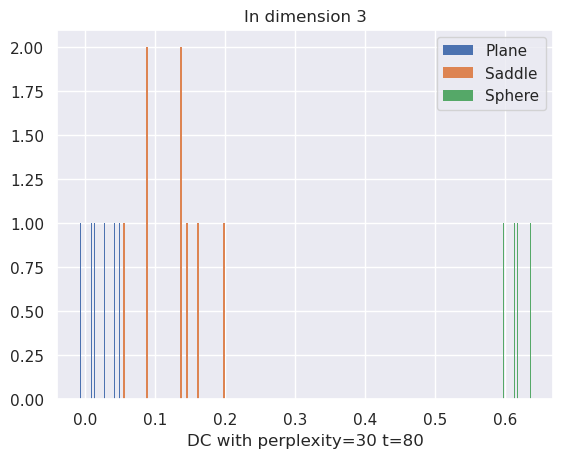

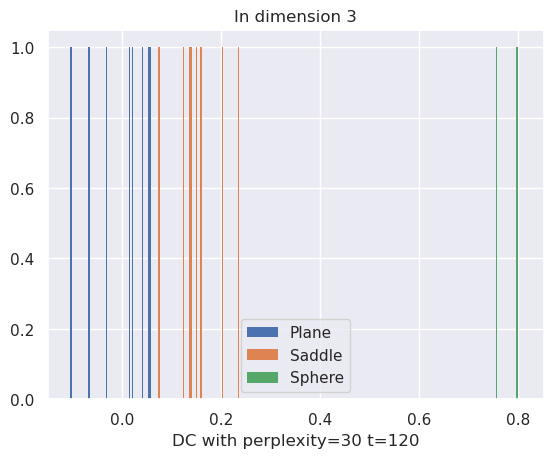

pearson_r  \
ks                                             (0.9999999999999999, 0.0)   
DC with perplexity=15 t=25      (0.3090227700257642, 0.1417457775909397)   
DC with perplexity=15 t=30     (0.3181632107278193, 0.12973302076260013)   
DC with perplexity=15 t=35     (0.3463550271762082, 0.09732100555919716)   
DC with perplexity=15 t=40    (0.45307435764379156, 0.02619065148289884)   
DC with perplexity=15 t=50    (0.42834726847535065, 0.03676951259010555)   
DC with perplexity=15 t=80    (0.4441384120155599, 0.029686942769815122)   
DC with perplexity=15 t=120  (0.48790154613204323, 0.015578015331621235)   
DC with perplexity=20 t=25    (0.19198060328438468, 0.36881163866297106)   
DC with perplexity=20 t=30     (0.3076771952650086, 0.14357906122660077)   
DC with perplexity=20 t=35    (0.4487320846419717, 0.027845808674498852)   
DC with perplexity=20 t=40     (0.3685207034006845, 0.07639997142181595)   
DC with perplexity=20 t=50    (0.4375182468526962, 0.032510044530420314)   
DC with perplexity=20 t=80     (0.4844148039974069, 0.01644819505719781)   
DC with perplexity=20 t=120   (0.5009086049141638, 0.012657240314179785)   
DC with perplexity=25 t=25     (0.3390505506666757, 0.10507016080277648)   
DC with perplexity=25 t=30    (0.39975067869785547, 0.05294142351113236)   
DC with perplexity=25 t=35    (0.43510189064498694, 0.03359215637005375)   
DC with perplexity=25 t=40     (0.4444638565826469, 0.02955338543363047)   
DC with perplexity=25 t=50    (0.4499327333015972, 0.027379995887899224)   
DC with perplexity=25 t=80   (0.48905043002036397, 0.015299675368522352)   
DC with perplexity=25 t=120   (0.5093302166708161, 0.011018519802180087)   
DC with perplexity=30 t=25      (0.3639220598154981, 0.0804313176666037)   
DC with perplexity=30 t=30   (0.39994431814479375, 0.052815925955352755)   
DC with perplexity=30 t=35   (0.44705773735051907, 0.028505978788320667)   
DC with perplexity=30 t=40     (0.4159475003668202, 0.04321780803350899)   
DC with perplexity=30 t=50    (0.48758932911788283, 0.01565436714125122)   
DC with perplexity=30 t=80    (0.5135985712763985, 0.010257373987763566)   
DC with perplexity=30 t=120  (0.49939724034892546, 0.012971522367217027)   

                             sign_score  
ks                             1.098612  
DC with perplexity=15 t=25     0.143841  
DC with perplexity=15 t=30     0.291219  
DC with perplexity=15 t=35     0.219512  
DC with perplexity=15 t=40     0.219512  
DC with perplexity=15 t=50     0.291219  
DC with perplexity=15 t=80     0.291219  
DC with perplexity=15 t=120    0.156249  
DC with perplexity=20 t=25     0.291219  
DC with perplexity=20 t=30     0.374890  
DC with perplexity=20 t=35     0.156249  
DC with perplexity=20 t=40     0.291219  
DC with perplexity=20 t=50     0.099391  
DC with perplexity=20 t=80     0.047615  
DC with perplexity=20 t=120    0.219512  
DC with perplexity=25 t=25     0.156249  
DC with perplexity=25 t=30     0.219512  
DC with perplexity=25 t=35     0.156249  
DC with perplexity=25 t=40     0.047615  
DC with perplexity=25 t=50     0.291219  
DC with perplexity=25 t=80     0.156249  
DC with perplexity=25 t=120    0.291219  
DC with perplexity=30 t=25     0.156249  
DC with perplexity=30 t=30     0.219512  
DC with perplexity=30 t=35     0.156249  
DC with perplexity=30 t=40     0.156249  
DC with perplexity=30 t=50     0.099391  
DC with perplexity=30 t=80     0.099391  
DC with perplexity=30 t=120    0.156249

In [ ]:
SS.plot()
SS.table()

# Symmetric Entropic Affinities - Dimension 2

In [ ]:
import asyncio
from tqdm import trange
dim = 2
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 26, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, perplexity, t):
    global SS
    graph_former = partial(SEA_graphformer, perplexity=perplexity)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=t)
    SS.update(ks[0], method_name=f"DC with {perplexity=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for perplexity in [15,20,25,30]:
        for t in [25,30,35,40,50,80,120]:
            tasks.append(asyncio.create_task(process_alpha_k(X, perplexity, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())



Processing X's:   0%|       | 0/24 [00:00<?, ?it/s]


  0%|                     | 0/1000 [00:00<?, ?it/s]


  0%|             | 5/1000 [00:00<00:20, 49.42it/s]


  1%|▏           | 11/1000 [00:00<00:18, 54.10it/s]


  2%|▏           | 17/1000 [00:00<00:17, 56.73it/s]


  2%|▎           | 23/1000 [00:00<00:17, 57.15it/s]


  3%|▎           | 29/1000 [00:00<00:16, 57.62it/s]


  4%|▍           | 35/1000 [00:00<00:16, 58.06it/s]


  4%|▍           | 41/1000 [00:00<00:16, 58.42it/s]


  5%|▌           | 48/1000 [00:00<00:16, 59.06it/s]


  5%|▋           | 54/1000 [00:00<00:15, 59.15it/s]


  6%|▋           | 61/1000 [00:01<00:15, 59.90it/s]


  7%|▊           | 68/1000 [00:01<00:15, 60.32it/s]


  8%|▉           | 75/1000 [00:01<00:15, 60.62it/s]


  8%|▉           | 82/1000 [00:01<00:15, 60.36it/s]


  9%|█           | 89/1000 [00:01<00:15, 60.61it/s]


 10%|█▏          | 96/1000 [00:01<00:14, 60.67it/s]


 10%|█▏         | 103/1000 [00:01<00:14, 60.45it/s]


 11%|█▏         | 110/1000

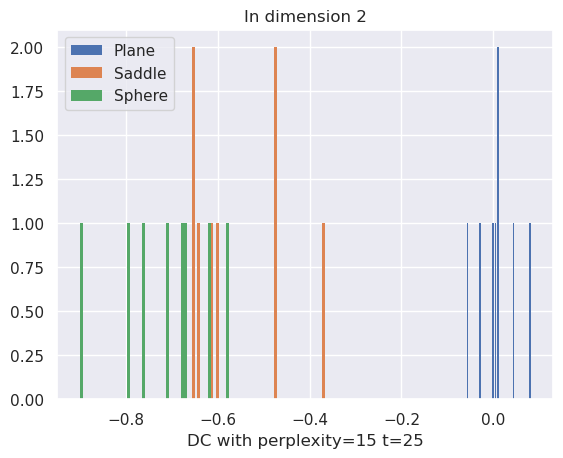

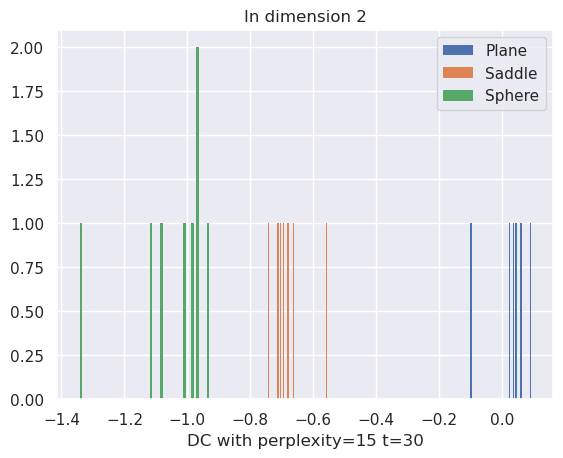

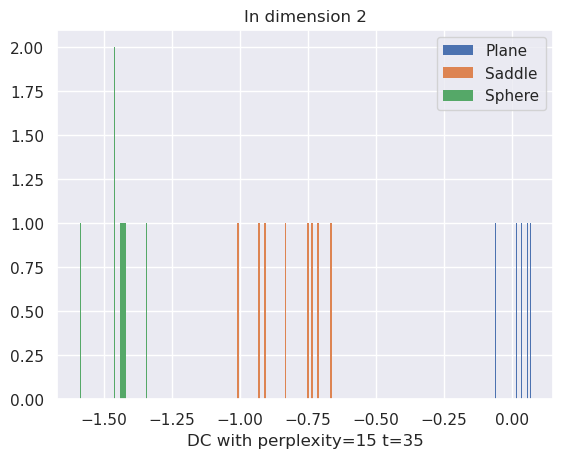

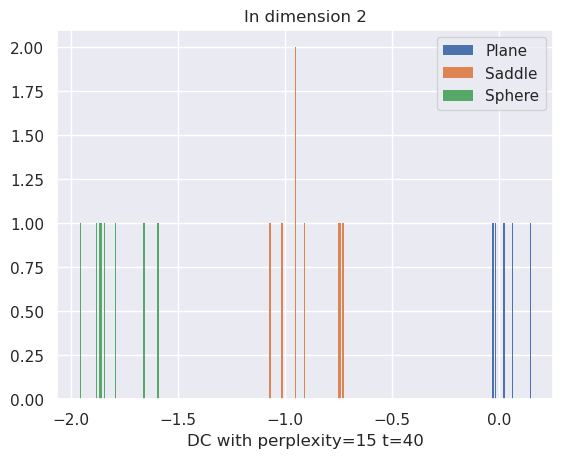

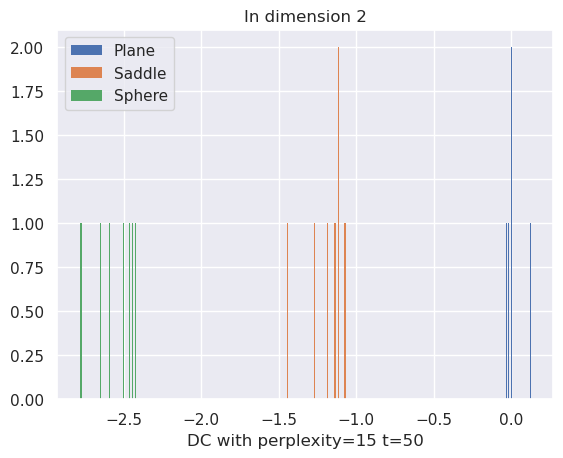

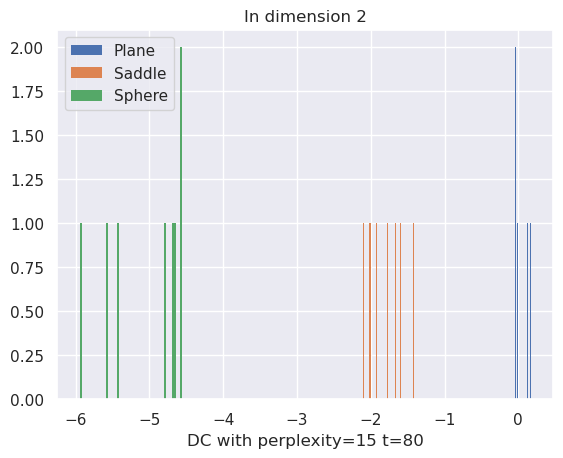

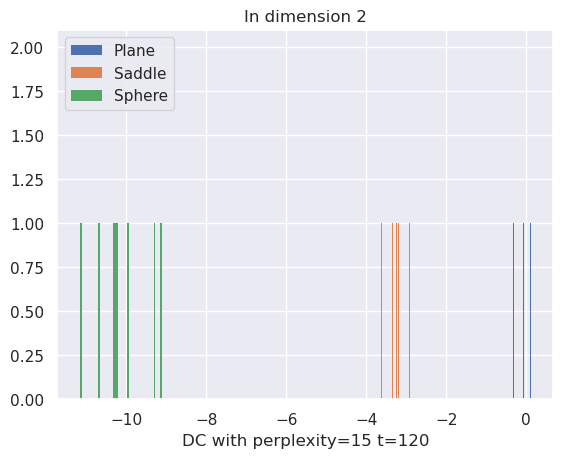

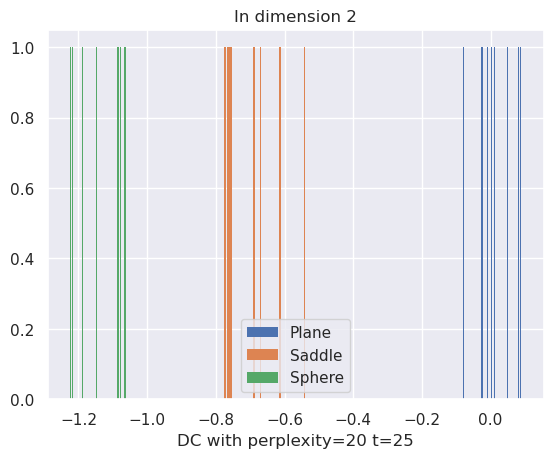

Processing X's:   0%|    | 0/26 [13:50:56<?, ?it/s]


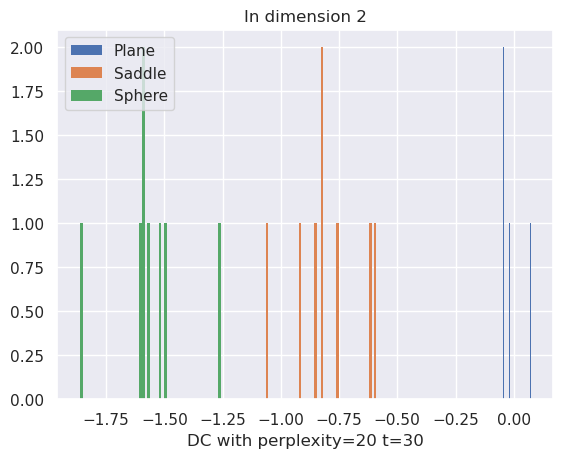

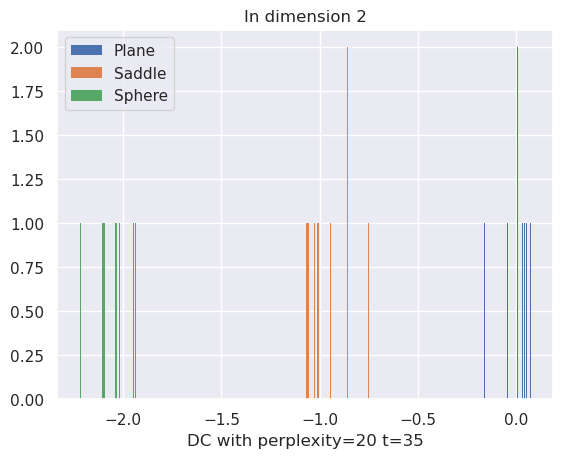

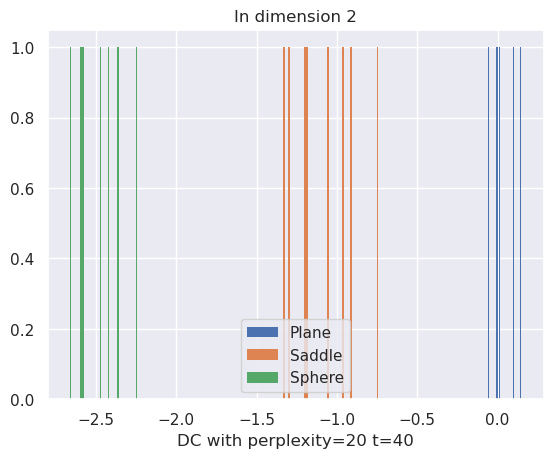

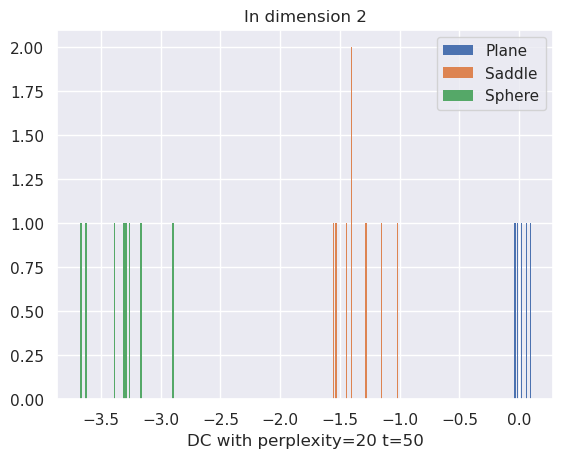

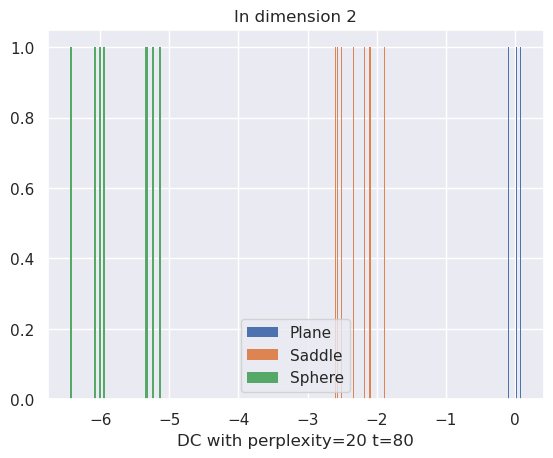

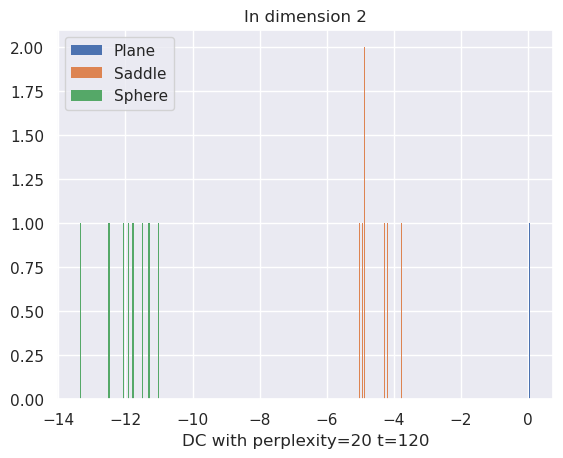

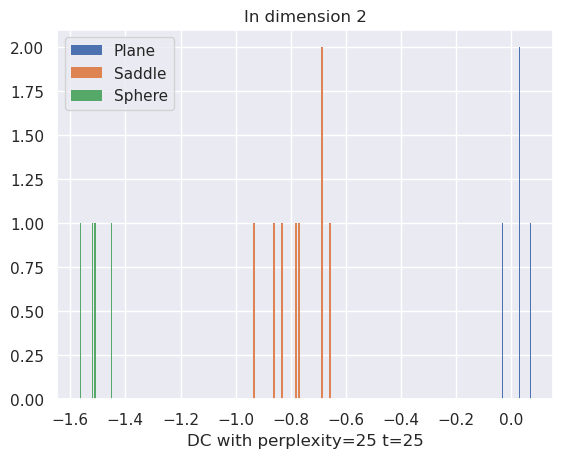

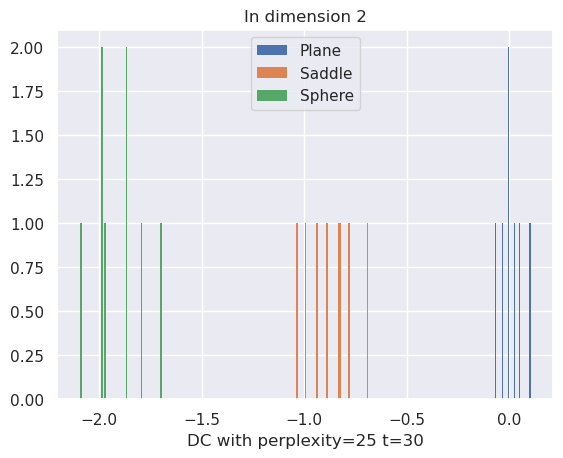

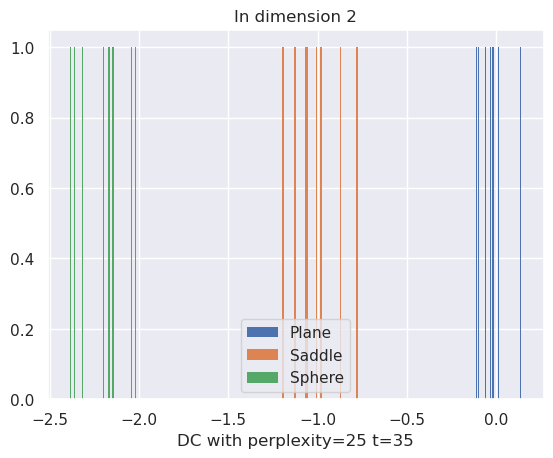

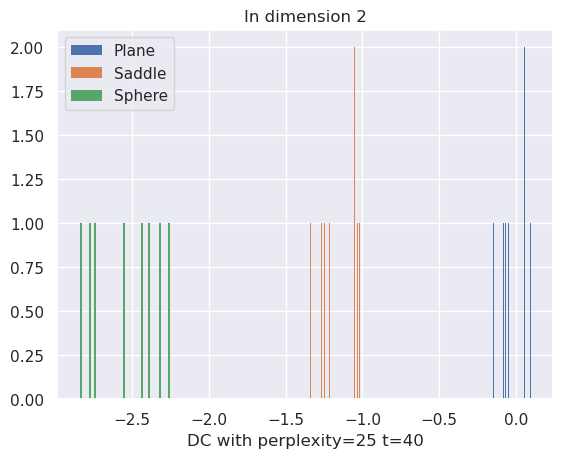

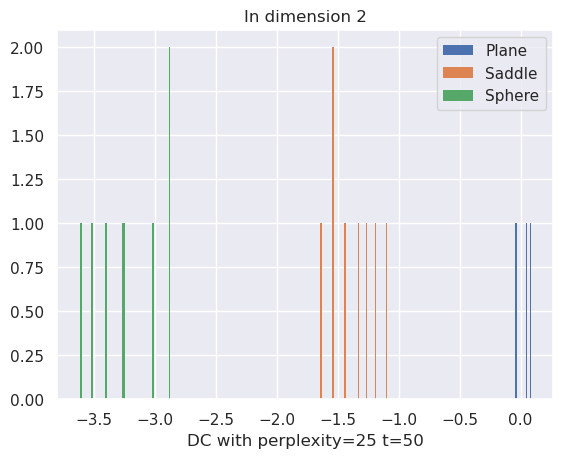

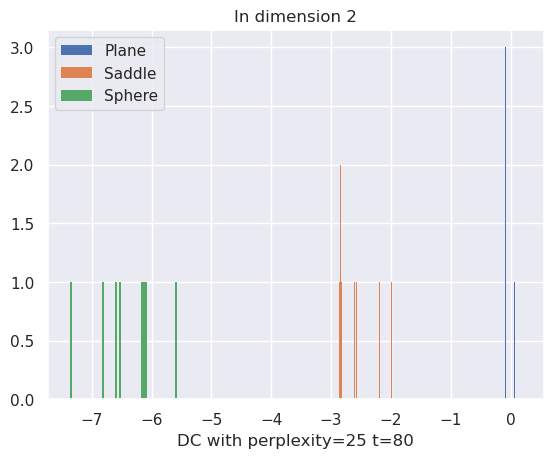

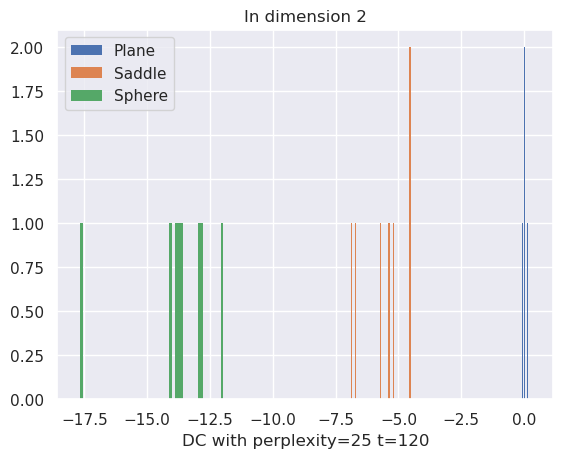

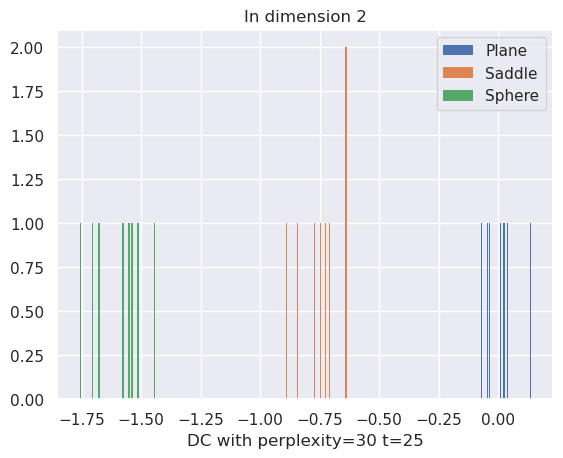

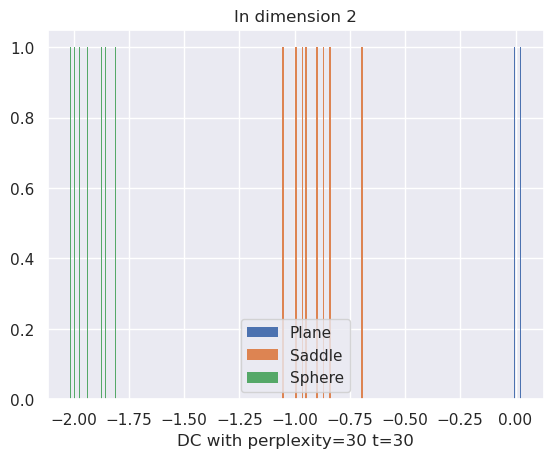

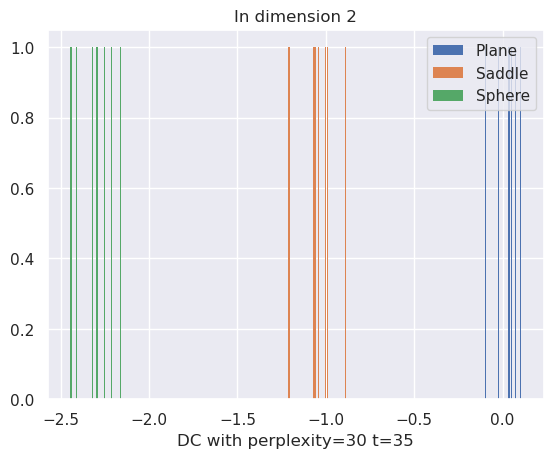

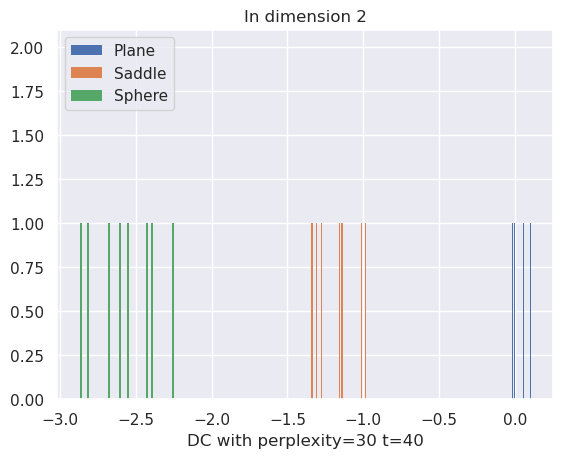

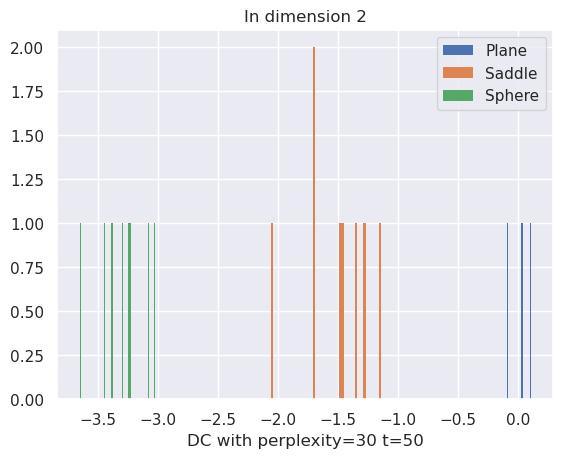

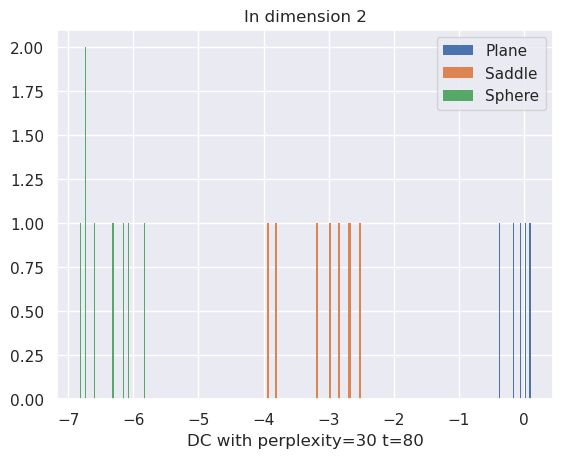

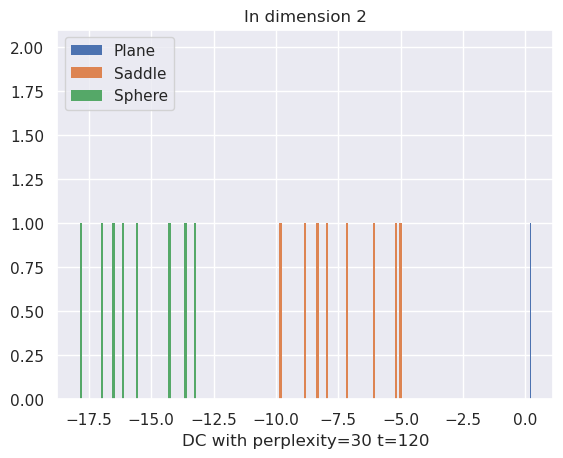

pearson_r  \
ks                                             (0.9999999999999999, 0.0)   
DC with perplexity=15 t=25     (0.12478663105304105, 0.5612601593021027)   
DC with perplexity=15 t=30   (-0.010203013136370762, 0.9622605390824386)   
DC with perplexity=15 t=35    (-0.10738212380737727, 0.6174780122347538)   
DC with perplexity=15 t=40    (-0.18968555174533977, 0.3746716687920585)   
DC with perplexity=15 t=50    (-0.23061464856375816, 0.2782929489044875)   
DC with perplexity=15 t=80    (-0.3392845536321706, 0.10481506571486082)   
DC with perplexity=15 t=120    (-0.3757094071626221, 0.0704073670736158)   
DC with perplexity=20 t=25    (-0.05501734994790258, 0.7984654951680621)   
DC with perplexity=20 t=30   (-0.16538283214260271, 0.43993889737539993)   
DC with perplexity=20 t=35    (-0.23061775046456123, 0.2782863037895935)   
DC with perplexity=20 t=40    (-0.24887689138464567, 0.2409077806205103)   
DC with perplexity=20 t=50    (-0.2917339107615632, 0.16660040848821328)   
DC with perplexity=20 t=80   (-0.29390406227987076, 0.16332404249339263)   
DC with perplexity=20 t=120    (-0.318631997524839, 0.12913740178052885)   
DC with perplexity=25 t=25   (-0.17533979049855272, 0.41249681367846314)   
DC with perplexity=25 t=30    (-0.2281851942710187, 0.28352833800954474)   
DC with perplexity=25 t=35      (-0.2408198017297112, 0.256973717989423)   
DC with perplexity=25 t=40      (-0.240500487865458, 0.2576243358400422)   
DC with perplexity=25 t=50   (-0.27011026673518435, 0.20177531710785337)   
DC with perplexity=25 t=80   (-0.29144616182021493, 0.16703825829114932)   
DC with perplexity=25 t=120  (-0.29495906980478903, 0.16174767967567438)   
DC with perplexity=30 t=25   (-0.22050224049388742, 0.30049013387357437)   
DC with perplexity=30 t=30     (-0.22213462792706756, 0.296834782258459)   
DC with perplexity=30 t=35    (-0.23064328842651083, 0.2782315983480138)   
DC with perplexity=30 t=40   (-0.23685919121968552, 0.26511876285616365)   
DC with perplexity=30 t=50   (-0.22852670087159618, 0.28278868250192046)   
DC with perplexity=30 t=80    (-0.2137077877643873, 0.31600278851388197)   
DC with perplexity=30 t=120   (-0.21874467227939307, 0.3044568376761719)   

                             sign_score  
ks                             1.098612  
DC with perplexity=15 t=25     0.291219  
DC with perplexity=15 t=30     0.478047  
DC with perplexity=15 t=35     0.374890  
DC with perplexity=15 t=40     0.219512  
DC with perplexity=15 t=50     0.374890  
DC with perplexity=15 t=80     0.156249  
DC with perplexity=15 t=120    0.219512  
DC with perplexity=20 t=25     0.291219  
DC with perplexity=20 t=30     0.219512  
DC with perplexity=20 t=35     0.374890  
DC with perplexity=20 t=40     0.291219  
DC with perplexity=20 t=50     0.219512  
DC with perplexity=20 t=80     0.291219  
DC with perplexity=20 t=120    0.099391  
DC with perplexity=25 t=25     0.219512  
DC with perplexity=25 t=30     0.219512  
DC with perplexity=25 t=35     0.099391  
DC with perplexity=25 t=40     0.219512  
DC with perplexity=25 t=50     0.156249  
DC with perplexity=25 t=80     0.219512  
DC with perplexity=25 t=120    0.291219  
DC with perplexity=30 t=25     0.291219  
DC with perplexity=30 t=30     0.219512  
DC with perplexity=30 t=35     0.374890  
DC with perplexity=30 t=40     0.156249  
DC with perplexity=30 t=50     0.291219  
DC with perplexity=30 t=80     0.219512  
DC with perplexity=30 t=120    0.156249

In [ ]:
SS.plot()
SS.table()

# Symmetric Entropic Affinities - Dimension 3

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 26, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, perplexity, t):
    global SS
    graph_former = partial(SEA_graphformer, perplexity=perplexity)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim=dim, t=t)
    SS.update(ks[0], method_name=f"DC with {perplexity=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for perplexity in [15,20,25,30]:
        for t in [25,30,35,40,50,80,120]:
            tasks.append(asyncio.create_task(process_alpha_k(X, perplexity, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

In [ ]:
SS.plot()
SS.table()

# Results

# Conclusion